In [1]:
from IPython.display import display, Markdown
import spacy
from spacy.language import Language
from spacy.matcher import PhraseMatcher
from spacy.tokens import Doc, Span
from collections import Counter
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re

In [2]:
df = pd.read_excel('../../../data/raw/OMIEC_NEUROMORPHIC_20_08_24.xls')

In [3]:
class CoOcurrence:
    def __init__(self, abstracts, focus_terms=None, svg_name='test_file.svg'):
        self.nlp = spacy.load("en_core_web_sm")
        self.abstracts = abstracts
        self.focus_terms = focus_terms or []  # Default to an empty list if not provided
        self.svg_name = svg_name
        self.setup_pipeline()
        self.docs = list(self.nlp.pipe(self.abstracts))

        # If focus_terms is empty, use the most common terms as focus terms
        if not self.focus_terms:
            self.focus_terms = self.get_most_common_terms()

        self.num_focus_terms = len(self.focus_terms)
        self.focus_term_indices = self.find_focus_term_indices()

    def setup_pipeline(self):
        @Language.component("custom_preprocessing")
        def custom_preprocessing(doc):
            preprocessed_text = self.preprocess_text(doc.text)
            return Doc(self.nlp.vocab, words=preprocessed_text.split())
        
        self.nlp.add_pipe("custom_preprocessing", first=True)
        
        @Language.component("merge_phrases")
        def merge_phrases(doc):
            matches = self.matcher(doc)
            with doc.retokenize() as retokenizer:
                for match_id, start, end in matches:
                    span = Span(doc, start, end, label="COMPOUND")
                    retokenizer.merge(span)
            return doc

        self.nlp.add_pipe("merge_phrases", before="ner")
        self.matcher = PhraseMatcher(self.nlp.vocab)
        patterns = [self.nlp.make_doc(text) for text in ["p-type", "n-type", "vertical-oects", "horizontal-oects"]]
        self.matcher.add("SPECIFIC_TERMS", patterns)

    def preprocess_text(self, text):
        text = re.sub(r'\bv-OECTs\b', 'vertical-oects', text, flags=re.IGNORECASE)
        text = re.sub(r'\bv-\s*OECTs\b', 'vertical-oects', text, flags=re.IGNORECASE)
        text = re.sub(r'\bp-OECTs\b', 'parallel-oects', text, flags=re.IGNORECASE)
        text = re.sub(r'\bp-\s*OECTs\b', 'parallel-oects', text, flags=re.IGNORECASE)
        text = re.sub(r'\bp-\s+(and)', r'p-type \1', text)
        text = re.sub(r'\bn-\s+(and)', r'n-type \1', text)
        text = re.sub(r'oects', r'oect', text, flags=re.IGNORECASE)
        text = re.sub(r'omiec', r'omiec', text, flags=re.IGNORECASE)

        units = {"V", "V-1", "mV", "μV", "nm", "μm", "ms", "us", "ns"}
        tokens = text.split()
        filtered_tokens = [token for token in tokens if token not in units]

        return " ".join(filtered_tokens)

    def postprocess_tokens(self, tokens):
        processed_tokens = []
        for lemma, pos in tokens:
            if len(lemma) < 2:
                continue
            if pos not in ["NOUN", "ADJ"]:
                continue
            if lemma.isnumeric():
                continue
            processed_tokens.append((lemma, pos))
        
        return processed_tokens

    def get_most_common_terms(self, num_terms=20):
        """Extract the most common terms from the documents."""
        filtered_tokens = np.concatenate([
            [(token.lemma_, token.pos_) for token in doc if not token.is_stop and not token.is_punct]
            for doc in self.docs
        ])

        filtered_tokens = self.postprocess_tokens(filtered_tokens)

        # Count term frequency for nouns and adjectives
        term_freq = Counter(token[0] for token in filtered_tokens if token[1] in ["NOUN", "ADJ"])

        # Get the most common terms
        common_terms = [term for term, _ in term_freq.most_common(num_terms)]
        return common_terms

    def find_focus_term_indices(self):
        focus_term_indices = {term: [] for term in self.focus_terms}
        
        for i, doc in enumerate(self.docs):
            doc_lemmas = {token.lemma_ for token in doc if not token.is_stop and not token.is_punct}
            for term in self.focus_terms:
                if term in doc_lemmas:
                    focus_term_indices[term].append(i)
        
        return focus_term_indices

    def analyze(self):
        filtered_tokens = np.concatenate([
            [(token.lemma_, token.pos_) for token in doc if not token.is_stop and not token.is_punct]
            for doc in self.docs
        ])

        filtered_tokens = self.postprocess_tokens(filtered_tokens)

        term_freq = Counter(token[0] for token in filtered_tokens if token[1] in ["NOUN", "ADJ"])

        common_terms = term_freq.most_common(20)

        # Display the most common terms in Markdown format
        md_output_common = "### Most Common Terms\n\n"
        for term, freq in common_terms:
            md_output_common += f"- **{term}**: {freq} occurrences\n"

        display(Markdown(md_output_common))

        print("\nIndices of abstracts where the focus terms occur:")
        for term, indices in self.focus_term_indices.items():
            print(f"Term '{term}' found in abstracts with indices: {indices}")

        G = nx.Graph()

        edges = [
            (token.lemma_, child.lemma_)
            for doc in self.docs
            for token in doc
            if not token.is_stop and not token.is_punct and token.pos_ in ["NOUN", "ADJ"]
            for child in token.children
            if child.pos_ in ["NOUN", "ADJ"]
        ]
        G.add_edges_from(edges)

        # Filter out focus terms that are not present in the graph
        valid_focus_terms = [term for term in self.focus_terms if term in G.nodes]

        # Build subgraph for valid focus terms
        subG = nx.Graph((term, neighbor) for term in valid_focus_terms for neighbor in G.neighbors(term))

        if len(subG.nodes) == 0:
            print("No connections found between focus terms or other terms.")
            return

        common_nodes = {
            node for node in subG.nodes()
            if sum(1 for term in valid_focus_terms if node in nx.neighbors(subG, term)) > 1
        }

        colormap = plt.colormaps['tab10']
        colors = [colormap(i / len(valid_focus_terms)) for i in range(len(valid_focus_terms))]
        focus_term_colors = {term: mcolors.to_hex(color) for term, color in zip(valid_focus_terms, colors)}

        blend_colors = lambda colors: mcolors.to_hex(tuple(sum(x)/len(x) for x in zip(*map(mcolors.to_rgb, colors))))

        node_colors = [
            focus_term_colors[node] if node in valid_focus_terms else
            blend_colors([focus_term_colors[term] for term in valid_focus_terms if node in nx.neighbors(subG, term)]) if node in common_nodes else
            'orange'
            for node in subG.nodes()
        ]

        plt.figure(figsize=(10*len(valid_focus_terms), 10*len(valid_focus_terms)))

        pos = nx.spring_layout(subG, k=0.5, iterations=50)

        nx.draw(
            subG, pos, 
            with_labels=True, 
            node_size=5000, 
            node_color=node_colors, 
            font_size=12, 
            font_weight='bold',
            edge_color='gray', 
            linewidths=1.5, 
            alpha=0.8
        )

        plt.title("Co-Occurrence Graph", fontsize=30)
        plt.savefig(f'images/{self.svg_name}')
        plt.show()

        subgraph_terms = set(subG.nodes())
        search_terms = [term for term, _ in common_terms if term in subgraph_terms]

        if not search_terms:
            search_terms = ['>>None<<']

        # Display recommended search terms in Markdown format
        md_output_search = "### Recommended Search Terms\n\n"
        for term in search_terms:
            md_output_search += f"- **{term}**\n"

        display(Markdown(md_output_search))

    def show_abstract(self, index):
        return display(Markdown(self.abstracts[index]))

### Most Common Terms

- **organic**: 200 occurrences
- **neuromorphic**: 171 occurrences
- **electrochemical**: 169 occurrences
- **transistor**: 137 occurrences
- **oect**: 133 occurrences
- **device**: 122 occurrences
- **ion**: 87 occurrences
- **mixed**: 80 occurrences
- **high**: 74 occurrences
- **material**: 68 occurrences
- **electronic**: 65 occurrences
- **polymer**: 64 occurrences
- **application**: 63 occurrences
- **conductor**: 63 occurrences
- **channel**: 58 occurrences
- **synaptic**: 58 occurrences
- **performance**: 50 occurrences
- **circuit**: 48 occurrences
- **low**: 48 occurrences
- **bioelectronic**: 46 occurrences



Indices of abstracts where the focus terms occur:
Term 'omiec' found in abstracts with indices: [1, 2, 3, 4, 5, 6, 9, 10, 12, 13, 14, 16, 18, 19]
Term 'oect' found in abstracts with indices: [1, 5, 9, 11, 16, 31, 38, 40, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 54, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 70, 71, 73, 74, 75, 76, 79, 80, 82, 83, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113]
Term 'neuromorphic' found in abstracts with indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]


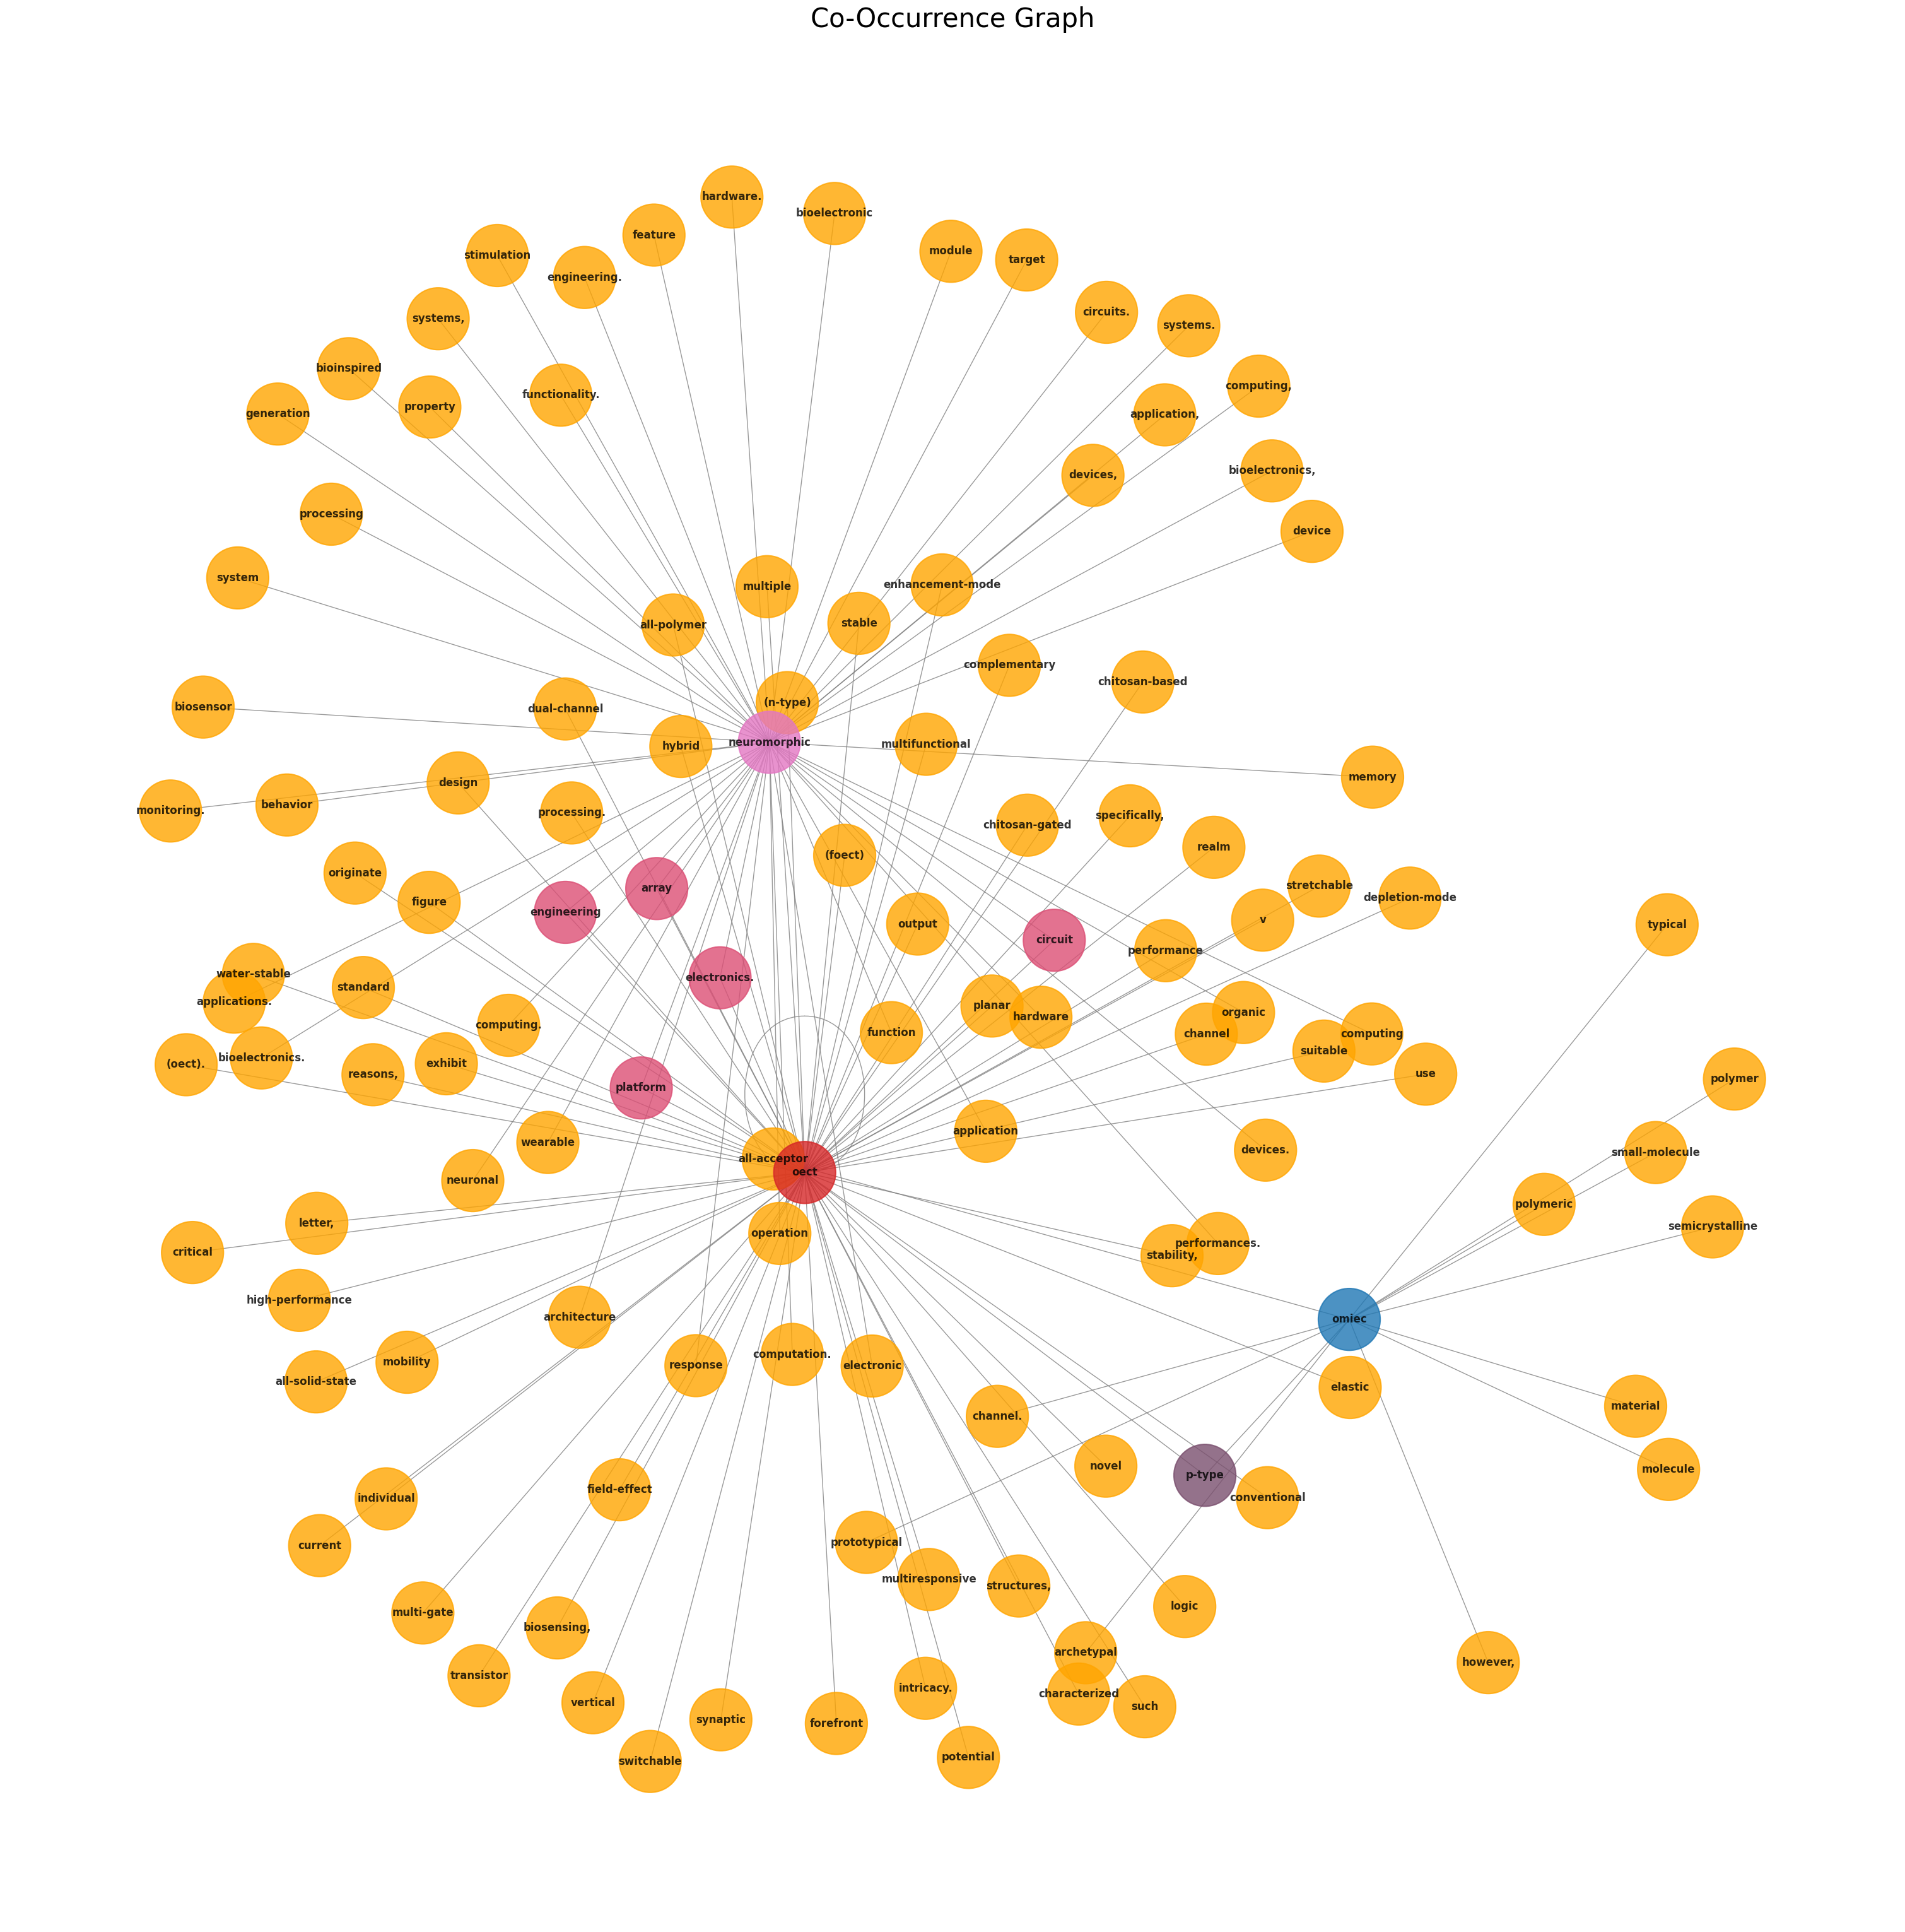

### Recommended Search Terms

- **organic**
- **neuromorphic**
- **transistor**
- **oect**
- **device**
- **material**
- **electronic**
- **polymer**
- **application**
- **channel**
- **synaptic**
- **performance**
- **circuit**
- **bioelectronic**


In [4]:
focus_terms = ['omiec','oect','neuromorphic']  # Substitua pelos termos de interesse

analyzer = CoOcurrence(df['Abstract'], focus_terms,svg_name='grafo_global_tst.png')
analyzer.analyze()

In [5]:
analyzer.show_abstract(40)

Organic electrochemical transistors (OECTs) using aqueous gate dielectrics have garnered significant interest for bioelectronic applications. However, their viability for long-term use in neuromorphic computing and synaptic devices is limited due to their short-term functionality. In this study, we synthesize two benzodifurandione-based oligo ( p -phenylene vinylene) polymers, BDOPV-TCNVT and ClBDOPV-TCNVT, and investigate their electrochemical transistor properties using quasi -solid-state ion gel -gated vertical OECTs ( v -OECTs). Compared to BDOPV-TCNVT, the chlorinated ClBDOPV-TCNVT demonstrates lower frontier molecular orbitals and easier electrochemical doping. The higher volumetric capacitance of as -spun ClBDOPV-TCNVT (1.94 F cm -3 ) compared to as -spun BDOPV-TCNVT films (1.49 F cm -3 ) is mainly attributed to the easier ion infiltration resulting from its lower crystallinity with mixed chain orientation. The quasi -solid-state v -OECTs based on both polymers (as -spun) exhibit transconductance ( g m ) of 0.06 -0.08 mS. Following thermal treatments, the g m gradually decreases for both polymers due to enhanced edge -on ordering with tight interchain packing, hindering ion penetration. Despite the poor electrochemical doping by quasi -solid-state ion gel gated dielectrics, the enlarged area and decreased channel length in v- OECTs (compared to parallel OECTs) can enhance the g m . Further optimization of v- OECTs requires tailored material designs specifically suited for efficient vertical charge transport together with ion infiltration.

### Playground